In [1]:
# install the required packages first
require(jsonlite)
require(httr)
require(data.table)

get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}



send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:length(predictions)){
        if(i<length(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    print(submission)

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

check_format <- function(predictions){
    
    if(all(is.numeric(predictions)) & all(predictions<=1)){
        print("Format OK")
        return(TRUE)
    } else {
        print("Wrong format")
        return(FALSE)
    }
    
}

# this part is main code
subm_url = 'http://46.101.121.83'

u_name = "Miners"
p_word = "NsY7hhlU9zjl8DH3"
submit_now = TRUE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
# this part is where you need to provide your prediction method/function or set of R codes


Loading required package: jsonlite
Loading required package: httr
Warning message:
"package 'httr' was built under R version 3.6.3"Loading required package: data.table


In [2]:
library(data.table)

### Performance Function

In [3]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Dataset

In [4]:
data_train=fread("IE582_Fall20_ProjectTrain.csv")
data_test=fread("IE582_Fall20_ProjectTest.csv")
data_train$y=as.factor(data_train$y)


In [5]:
levels(data_train$y)=c("No","Yes")

# Model

In [6]:
library(xlsx)
library(caret)
library(e1071)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(Information)
library(FactoMineR)
library(caTools)
library(ROCR)
library(pROC)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'caret'

The following object is masked from 'package:httr':

    progress

Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.2.1 --
<U+221A> tibble  3.0.4     <U+221A> purrr   0.3.2
<U+221A> tidyr   1.1.2     <U+221A> stringr 1.4.0
<U+221A> readr   1.3.1     <U+221A>

# Metric Creation

In [7]:
library(yardstick)
library(mlbench)
library(cvAUC)
library(forecast)

Warning message:
"package 'yardstick' was built under R version 3.6.3"For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.

Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

The following objects are masked from 'package:caret':

    precision, recall, sensitivity, specificity

Warning message:
"package 'mlbench' was built under R version 3.6.3"Warning message:
"package 'cvAUC' was built under R version 3.6.3" 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 
Warning message:
"package 'forecast' was built under R version 3.6.2"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Attaching package: 'forecast'

The following object is masked from 'package:yardstick':

    accuracy



### Custom Metric

In [8]:
fourStats <- function (data, lev = levels(data$obs), model = NULL) { 
      auc_val=AUC(data$Yes, data$obs)
      
      out <- c(twoClassSummary(data, lev = levels(data$obs), model = NULL))
      coords <- matrix(c(1, 1, out["Spec"], out["Sens"]), 
                   ncol = 2, 
                   byrow = TRUE)
      #print(out)  
  #print(BER(data$obs, data$pred))
      colnames(coords) <- c("Spec", "Sens")
      rownames(coords) <- c("Best", "Current") 
      a=as.numeric((auc_val+(coords[2]+coords[4])/2)/2)+coords[2]/10
      c(AUC_value=auc_val, Prime=a, Spec=coords[4], Sens=coords[2])
}

## Grid Types

#### Random Forest

In [9]:
rf_grid=expand.grid(mtry=c(8,10,12,15,20),
                   splitrule = c("extratrees","gini","hellinger"),
                   min.node.size= c(5,10,15,20,25))

#### SGB

In [10]:
gbmGrid=expand.grid(interaction.depth = c(1,3,5,8), 
                        n.trees = (1:6)*50, 
                        shrinkage = c(0.1, 0.05, 0.01),
                        n.minobsinnode = c(5,10,15))

#### XGBoost

In [11]:
xgbGrid=expand.grid(max_depth = c(3, 5), 
                        nrounds = (2:4)*50, 
                        eta = c(0.1, 0.3),
                        min_child_weight=c(1,5),
                        gamma=c( 1, 1.5, 2),
                        colsample_bytree=c(0.8),
                        subsample=c(0.8))

### Cross-Validation

In [12]:
fitControl_random=trainControl(method = "repeatedcv",
                               number = 10, repeats=4, summaryFunction = fourStats,
                              classProbs = T, 
                              verboseIter=FALSE)

# Random Forest

In [13]:
random_forest=train(y ~. , data = data_train, 
                 method = "ranger", 
                 trControl = fitControl_random, num.trees=400,
                 metric="Prime",
                 maximize=TRUE,
                 tuneGrid = rf_grid,
                 class.weights  = c(sum(data_train$y=="No")/nrow(data_train),sum(data_train$y=="Yes")/nrow(data_train)))

In [14]:
random_forest

Random Forest 

2074 samples
  60 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 4 times) 
Summary of sample sizes: 1868, 1867, 1866, 1866, 1866, 1867, ... 
Resampling results across tuning parameters:

  mtry  splitrule   min.node.size  AUC_value  Prime      Spec       Sens     
   8    extratrees   5             0.8728465  0.8449336  0.9298689  0.5029804
   8    extratrees  10             0.8724553  0.8426929  0.9292238  0.4975980
   8    extratrees  15             0.8730310  0.8451286  0.9289074  0.5039608
   8    extratrees  20             0.8724157  0.8430960  0.9289115  0.4990294
   8    extratrees  25             0.8723004  0.8447964  0.9317849  0.5020000
   8    gini         5             0.8826954  0.8664499  0.9480871  0.5373725
   8    gini        10             0.8838926  0.8665876  0.9490436  0.5353725
   8    gini        15             0.8833611  0.8642531  0.9496764  0.5290098
   8    gini        20             0.88

In [32]:
random_forest$final

Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = min(param$mtry, ncol(x)), min.node.size = param$min.node.size,      splitrule = as.character(param$splitrule), write.forest = TRUE,      probability = classProbs, ...) 

Type:                             Probability estimation 
Number of trees:                  400 
Sample size:                      2074 
Number of independent variables:  60 
Mtry:                             15 
Target node size:                 20 
Variable importance mode:         none 
Splitrule:                        hellinger 
OOB prediction error (Brier s.):  0.1112971 

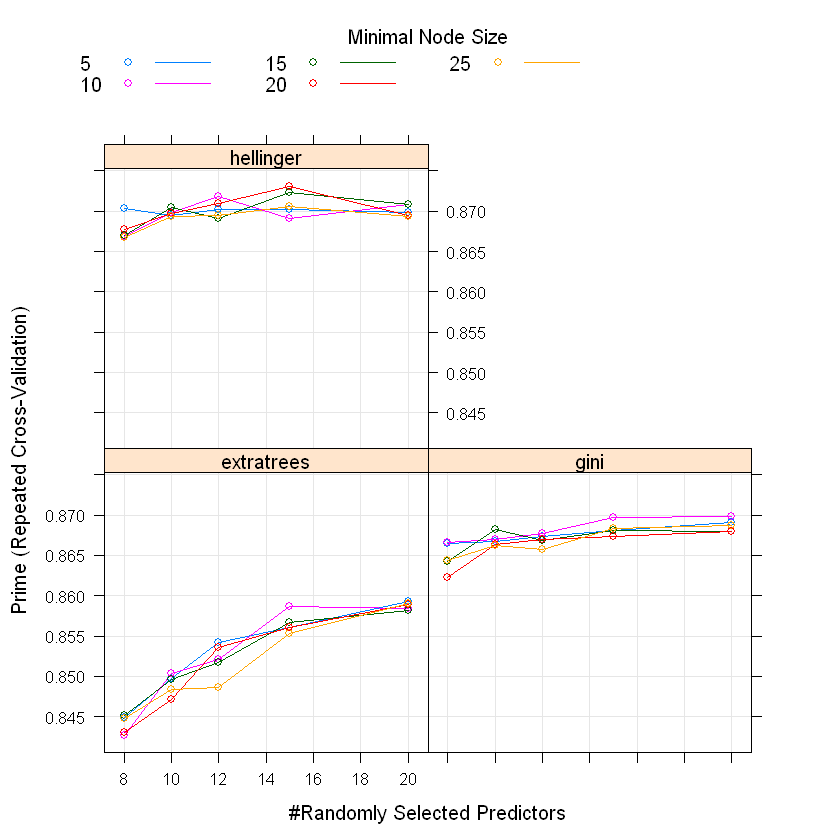

In [52]:
plot(random_forestforest)

In [15]:
pred_rf=predict(random_forest, data_test,type="prob")

In [16]:
sum(pred_rf$Yes<0.5)/nrow(pred_rf)

[1] 0.8205499

In [17]:
max(pred_rf$Yes)

[1] 0.9895117

In [18]:
pred_rf[,c(2)]=pred_rf[,c(2)]+(1-max(pred_rf[,c(2)]))

In [19]:
pred_rf=pred_rf[,2]

In [20]:
sum(pred_rf<0.5)/length(pred_rf)

[1] 0.8137964

# SGM

In [21]:
data_train_sgm=as.data.frame(data_train)
data_test_sgm=as.data.frame(data_test)

In [22]:
data_train_sgm=data_train_sgm[,c(-37,-50,-52)]
data_test_sgm=data_test_sgm[,c(-37,-50,-52)]

In [23]:
gbm_dt=train(y ~ ., data = data_train_sgm, 
                 method = "gbm", 
                 trControl = fitControl_random,
                 metric="Prime",
                 tuneGrid = gbmGrid,
                 verbose=F)

In [24]:
gbm_dt

Stochastic Gradient Boosting 

2074 samples
  57 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 4 times) 
Summary of sample sizes: 1867, 1867, 1866, 1866, 1868, 1866, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  AUC_value  Prime    
  0.01       1                   5               50      0.8361434  0.6680717
  0.01       1                   5              100      0.8490703  0.7096175
  0.01       1                   5              150      0.8628701  0.7312997
  0.01       1                   5              200      0.8683852  0.7356049
  0.01       1                   5              250      0.8705526  0.7573234
  0.01       1                   5              300      0.8734817  0.7842229
  0.01       1                  10               50      0.8355829  0.6677915
  0.01       1                  10              100      0.8503892  0.7097622
  0.01       1          

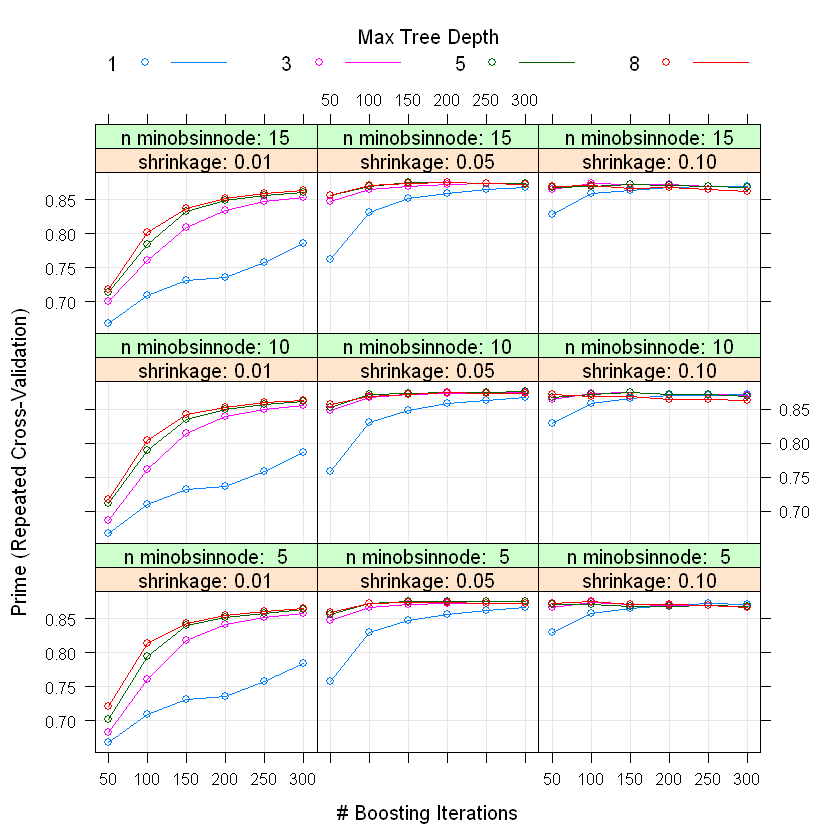

In [55]:
plot(gbm_dt)

In [56]:
gbm_dt$final

A gradient boosted model with bernoulli loss function.
200 iterations were performed.
There were 57 predictors of which 44 had non-zero influence.

### Prediction

In [25]:
pred_gbm=predict(gbm_dt, data_test_sgm,type="prob")

In [26]:
pred_gbm=pred_gbm[,2]

In [27]:
sum(pred_gbm<0.5)/length(pred_gbm)

[1] 0.8089725

In [28]:
pred_gbm=pred_gbm+(1-max(pred_gbm))

In [29]:
max(pred_gbm)

[1] 1

In [30]:
sum(pred_gbm<0.5)/length(pred_gbm)

[1] 0.8041486

# XGBoost

In [47]:
model_weights <- ifelse(data_train$y == "No",
                        table(data_train$y)[1]/nrow(data_train),
                        table(data_train$y)[2]/nrow(data_train))

In [48]:
xgboost_dt=train(y ~ ., data = data_train, 
                 method = "xgbTree", 
                 trControl = fitControl_random,
                 metric="Prime",  
                 tuneGrid = xgbGrid,
                 weights =model_weights,
                 verbose=F)

In [59]:
xgboost_dt

eXtreme Gradient Boosting 

2074 samples
  60 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 4 times) 
Summary of sample sizes: 1866, 1867, 1867, 1868, 1866, 1866, ... 
Resampling results across tuning parameters:

  eta  max_depth  gamma  min_child_weight  nrounds  AUC_value  Prime    
  0.1  3          1.0    1                 100      0.8872125  0.8087736
  0.1  3          1.0    1                 150      0.8859315  0.8165511
  0.1  3          1.0    1                 200      0.8843923  0.8202129
  0.1  3          1.0    5                 100      0.8760740  0.7902668
  0.1  3          1.0    5                 150      0.8751365  0.7948719
  0.1  3          1.0    5                 200      0.8733790  0.7976124
  0.1  3          1.5    1                 100      0.8861084  0.8022672
  0.1  3          1.5    1                 150      0.8855482  0.8091193
  0.1  3          1.5    1                 200      0.8850806  0.8110645

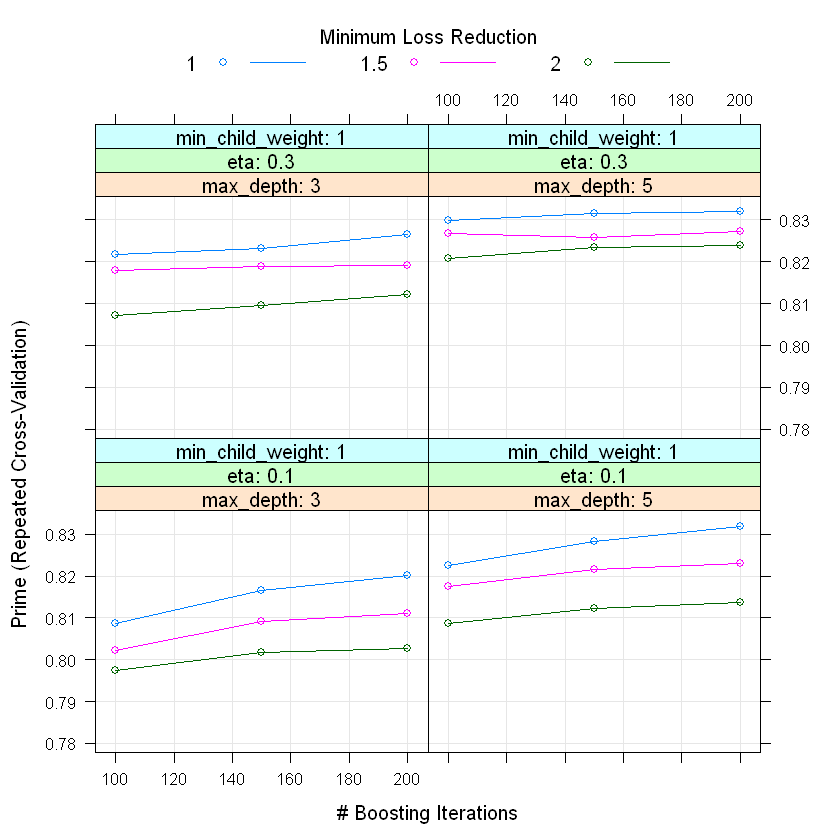

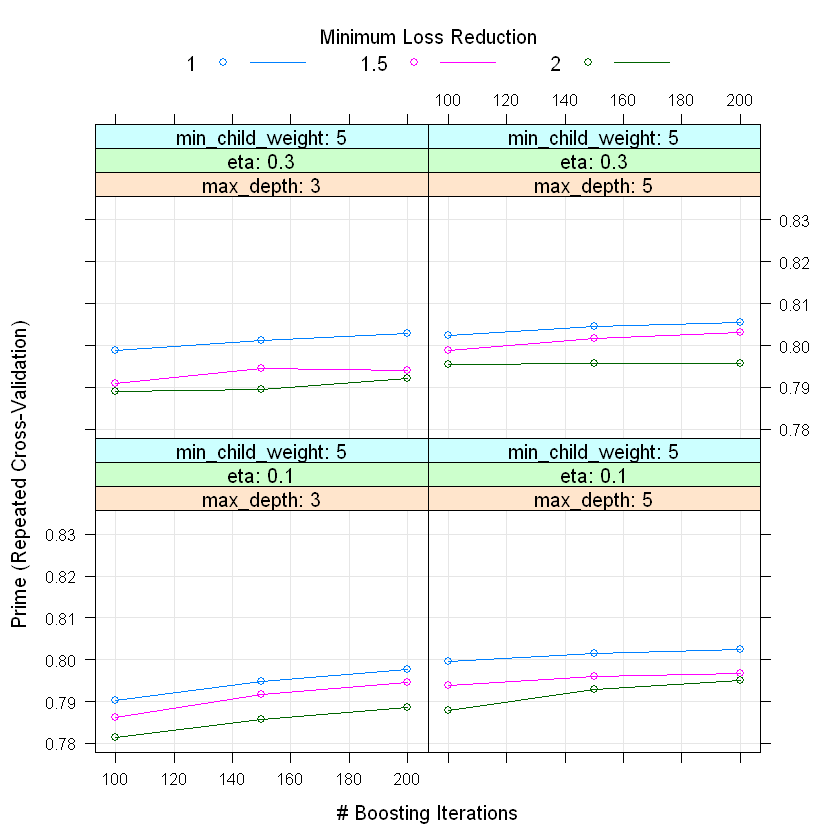

In [57]:
plot(xgboost_dt)

In [58]:
xgboost_dt$final

##### xgb.Booster
raw: 441.1 Kb 
call:
  xgboost::xgb.train(params = list(eta = param$eta, max_depth = param$max_depth, 
    gamma = param$gamma, colsample_bytree = param$colsample_bytree, 
    min_child_weight = param$min_child_weight, subsample = param$subsample), 
    data = x, nrounds = param$nrounds, verbose = ..1, objective = "binary:logistic")
params (as set within xgb.train):
  eta = "0.3", max_depth = "5", gamma = "1", colsample_bytree = "0.8", min_child_weight = "1", subsample = "0.8", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
# of features: 60 
niter: 200
nfeatures : 60 
xNames : x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19 x20 x21 x22 x23 x24 x25 x26 x27 x28 x29 x30 x31 x32 x33 x34 x35 x36 x37 x38 x39 x40 x41 x42 x43 x44 x45 x46 x47 x48 x49 x50 x51 x52 x53 x54 x55 x56 x57 x58 x59 x60 
problemType : Classification 
tuneValue :
	   nrounds max_depth eta gamma colsample_bytree min_child_weight subsample
57     200

In [49]:
pred_xgb=predict(xgboost_dt, data_test, type="prob")

In [50]:
pred_xgb=pred_xgb[,2]

In [64]:
sum(pred_xgb<0.5)/length(pred_xgb)

[1] 0.8465991

In [65]:
pred_xgb=pred_xgb+(1-max(pred_xgb))

In [66]:
max(pred_xgb)

[1] 1

In [178]:
# manys=0
# for(i in 1:length(last_num)){
#     if(last_num[i]<=0.5){
#         count=0
#         count1=0
#         sum=0
#         sum1=0
#         if(pred_rf[i]>0.35){
#             sum=pred_rf[i]+sum+0.155
#             count=count+1
#         }
#         if(pred_gbm[i]>0.35){
#             sum=pred_gbm[i]+sum+0.155
#             count=count+1
#         }
#         if(pred_xgb[i]>0.35){
#             sum=pred_xgb[i]+sum+0.155
#             count=count+1
#         }
#         else if(pred_rf[i]>0.24 & pred_gbm[i]>0.24){
#             sum1=(pred_rf[i]+pred_gbm[i])/2+sum1+0.265  
#             count1=count1+1
#         } 
#         else if(pred_gbm[i]>0.24 & pred_xgb[i]>0.24){
#             sum1=(pred_gbm[i]+pred_xgb[i])/2+sum1+0.265 
#             count1=count1+1
#         } 
#         else if(pred_rf[i]>0.24 & pred_xgb[i]>0.24){
#             sum1=(pred_rf[i]+pred_xgb[i])/2+sum1+0.265    
#             count1=count1+1
#         } 
#         else if(pred_rf[i]>0.22 & pred_gbm[i]>0.22 & pred_xgb[i]>0.22){
#             last_num[i]=((pred_rf[i]+pred_gbm[i]+pred_xgb[i])/3)+0.285     
#         } 
        
#         if(count>0){
#             manys=manys+(count/count)
#             last_num[i]=sum/count
#         }   
#         if(count1>0){
#             manys=manys+(count1/count1)
#             last_num[i]=sum1/count1
#         }  
#     }
# }

### Prediction

In [530]:
best_score=c(0.0243, 0.1196, 0.5796, 0.0206, 0.7544, 0.0983, 0.5166, 0.5507, 0.0586, 0.0165, 0.1557, 0.1847, 0.0221, 0.982, 0.1493, 0.0211, 0.0138, 0.0753, 0.1147, 0.0192, 0.0431, 0.5192, 0.9907, 0.0152, 0.6471, 0.0383, 0.507, 0.6167, 0.5269, 0.2041, 0.5684, 0.7552, 0.0163, 0.5845, 0.6334, 0.1548, 0.8487, 0.9277, 0.974, 0.0196, 0.0734, 0.1079, 0.0935, 0.7272, 0.1599, 0.7577, 0.1514, 0.018, 0.1296, 0.0409, 0.052, 0.0182, 0.1712, 0.5387, 0.9472, 0.532, 0.6582, 0.5614, 0.0658, 0.5269, 0.9829, 0.0107, 0.0263, 0.1141, 0.0446, 0.0303, 0.0113, 0.017, 0.8018, 0.0949, 0.7306, 0.0138, 0.0227, 0.8138, 0.0217, 0.1187, 0.5215, 0.0444, 0.5181, 0.044, 0.9588, 0.0367, 0.0104, 0.6275, 0.1356, 0.1807, 0.0136, 0.0586, 0.926, 0.205, 0.0403, 0.0323, 0.0699, 0.8609, 0.0983, 0.2023, 0.0546, 0.0485, 0.5135, 0.6137, 0.7175, 0.0233, 0.6119, 0.5313, 0.5327, 0.577, 0.0348, 0.2179, 0.1184, 0.0554, 0.0295, 0.7963, 0.0486, 0.5122, 0.1848, 0.0131, 0.0105, 0.2348, 0.034, 0.0231, 0.0325, 0.0329, 0.0192, 0.061, 0.072, 0.0166, 0.0229, 0.2285, 0.6949, 0.0278, 0.5968, 0.2275, 0.1644, 0.1936, 0.57, 0.501, 0.0401, 0.5029, 0.052, 0.5196, 0.537, 0.1779, 0.5185, 0.5775, 0.5214, 0.1239, 0.6353, 0.133, 0.1265, 0.063, 0.0291, 0.5055, 0.1061, 0.066, 0.0159, 0.1255, 0.018, 0.5801, 0.1738, 0.8824, 0.0665, 0.0589, 0.0263, 0.0916, 0.0204, 0.5521, 0.0423, 0.5106, 0.0165, 0.0895, 0.6923, 0.1828, 0.5294, 0.0217, 0.5378, 0.0154, 0.2063, 0.525, 0.5708, 0.955, 0.7672, 0.6778, 0.5447, 0.0134, 0.8034, 0.0192, 0.0128, 0.0927, 0.1276, 0.1346, 0.015, 0.5881, 0.5963, 0.1309, 0.0169, 0.0154, 0.0446, 0.0363, 0.0201, 0.7582, 0.5721, 0.0511, 0.0505, 0.5134, 0.2181, 0.5797, 0.0294, 0.8992, 0.0406, 0.7363, 0.0604, 0.0129, 0.0681, 0.5638, 0.1385, 0.666, 0.0886, 0.032, 0.0139, 0.0577, 0.0762, 0.017, 0.2504, 0.6716, 0.0557, 0.0313, 0.0921, 0.8503, 0.5432, 0.0153, 0.9164, 0.022, 0.5775, 0.0383, 0.0157, 0.0518, 0.5644, 0.0598, 0.6413, 0.565, 0.0467, 0.0324, 0.0228, 0.0479, 0.0326, 0.0249, 0.7086, 0.6566, 0.7318, 0.0141, 0.0385, 0.8998, 0.6239, 0.5115, 0.0242, 0.5783, 0.8155, 0.1809, 0.0335, 0.0495, 0.5327, 0.1493, 0.0431, 0.5254, 0.6455, 0.5582, 0.0252, 0.0783, 0.0584, 0.077, 0.5005, 0.1341, 0.1593, 0.1352, 0.0249, 0.1487, 0.5688, 0.0368, 0.1742, 0.1291, 0.1999, 0.0572, 0.1794, 0.1083, 0.5034, 0.2107, 0.0568, 0.5825, 0.6373, 0.5471, 0.2483, 0.0522, 0.2308, 0.5373, 0.5033, 0.9815, 0.6955, 0.0662, 0.0149, 0.0208, 0.7184, 0.0241, 0.0264, 0.0111, 0.037, 0.0492, 0.0694, 0.1461, 0.0468, 0.0187, 0.107, 0.525, 0.6463, 0.0391, 0.0241, 0.7871, 0.1357, 0.1248, 0.632, 0.5074, 0.0181, 0.0973, 0.0259, 0.1761, 0.1715, 0.553, 0.6798, 0.5746, 0.042, 0.192, 0.5664, 0.1401, 0.8642, 0.5103, 0.6676, 0.0953, 0.5501, 0.9113, 0.0162, 0.0563, 0.0791, 0.0512, 0.079, 0.1151, 0.5316, 0.0186, 0.0826, 0.1794, 0.036, 0.0557, 0.0529, 0.0222, 0.0776, 0.9399, 0.0525, 0.254, 0.9077, 0.0952, 0.1162, 0.1666, 0.0498, 0.0152, 0.0581, 0.1021, 0.6375, 0.5025, 0.6864, 0.0217, 0.0271, 0.0726, 0.918, 0.0751, 0.0167, 0.068, 0.0837, 0.8178, 0.072, 0.0337, 0.0214, 0.1887, 0.1427, 0.5399, 0.0314, 0.8311, 0.0959, 0.0518, 0.014, 0.5271, 0.0891, 0.2677, 0.0235, 0.0434, 0.6646, 0.0849, 0.0596, 0.2252, 0.0248, 0.0239, 0.0199, 0.0145, 0.0303, 0.9383, 0.0676, 0.7798, 0.0347, 0.5891, 0.0502, 0.16, 0.7304, 0.0528, 0.514, 0.0279, 0.559, 0.0162, 0.5971, 0.5172, 0.1514, 0.924, 0.5127, 0.594, 0.1752, 0.6218, 0.014, 0.0354, 0.1029, 0.5156, 0.0717, 0.5913, 0.0653, 0.6113, 0.6339, 0.0436, 0.5824, 0.1989, 0.6221, 0.1585, 0.0183, 0.1368, 0.6878, 0.5114, 0.1074, 0.0857, 0.0901, 0.9668, 0.0805, 0.5798, 0.0142, 0.016, 0.7798, 0.0174, 0.5887, 0.1543, 0.0348, 0.8741, 0.1104, 0.0121, 0.6252, 0.5837, 0.9462, 0.5949, 0.0479, 0.0797, 0.1046, 0.9129, 0.0369, 0.5294, 0.1159, 0.0272, 0.0279, 0.5886, 0.5032, 0.6311, 0.0514, 0.0524, 0.5, 0.0203, 0.1197, 0.9032, 0.2339, 0.0136, 0.0136, 0.0666, 0.9419, 0.068, 0.0126, 0.0595, 0.6913, 0.0388, 0.6264, 0.0429, 0.6067, 0.5791, 0.6886, 0.7167, 0.0661, 0.0211, 0.8318, 0.0152, 0.8396, 0.0516, 0.049, 0.0728, 0.0144, 0.0122, 0.0652, 0.0127, 0.5358, 0.5705, 0.0886, 0.0256, 0.7219, 0.5081, 0.0372, 0.0218, 0.0154, 0.1925, 0.0213, 0.0623, 0.5402, 0.6038, 0.0174, 0.0316, 0.551, 0.014, 0.1479, 0.4781, 0.0148, 0.7466, 0.1228, 0.0122, 0.1513, 0.0147, 0.5983, 0.5829, 0.6756, 0.0152, 0.9857, 0.5627, 0.2349, 0.1065, 0.1103, 0.9613, 0.0464, 0.0481, 0.1074, 0.0417, 0.6166, 0.6419, 0.0133, 0.6139, 0.0148, 0.0491, 0.0385, 0.8784, 0.5899, 0.5698, 0.047, 0.029, 0.0199, 0.2217, 0.0348, 0.0589, 0.0339, 0.0834, 0.1789, 0.014, 0.1692, 0.0318, 0.5364, 0.2318, 0.0363, 0.2314, 0.1479, 0.2393, 0.1939, 0.5434, 0.623, 0.1285, 0.0538, 0.0327, 0.0181, 0.0183, 0.5164, 0.6012, 0.1534, 0.5922, 0.0136, 0.0666, 0.1236, 0.0296, 0.8026, 0.1096, 0.03, 0.0107, 0.0184, 0.7884, 0.0207, 0.0305, 0.0273, 0.6268, 0.0297, 0.1931, 0.5532, 0.0314, 0.0619, 0.548, 0.9645, 0.083, 0.0664, 0.029, 0.1157, 0.6259, 0.6345, 0.0639, 0.0345, 0.6521, 0.0233, 0.1943, 0.1848, 0.9685, 0.0697, 0.5976, 0.9198, 0.8178, 0.5125, 0.197, 0.1242, 0.0143, 0.1946, 0.0818, 0.0692, 0.1196, 0.5269, 0.1667, 0.1987, 0.0153, 0.567, 0.122, 0.0147, 0.1049, 0.2032, 0.0542, 0.0146, 0.0721, 0.0421, 0.0191, 0.0657, 0.0487, 0.6532, 0.5099, 0.0598, 0.0522, 0.6461, 0.5482, 0.5101, 0.1354, 0.5095, 0.6401, 0.6146, 0.12, 0.5094, 0.0143, 0.0327, 0.5454, 0.1283, 0.1399, 0.5793, 0.0217, 0.0149, 0.7542, 0.6152, 0.1182, 0.0142, 0.7403, 0.517, 0.5305, 0.0207, 0.6253, 0.558, 0.4771, 0.0231, 0.9495, 0.0947, 0.1554, 0.0608, 0.5368, 0.2077, 0.5622, 0.0435, 0.1807, 0.0603, 0.0505, 0.5666, 0.522, 0.0295, 0.5718, 0.0467, 0.0718, 0.0275, 0.1928, 0.0657, 0.1813, 0.604, 0.0689, 0.6295, 0.7604, 0.5508, 0.0288, 0.2408, 0.0299, 0.5287, 0.9855, 0.0252, 0.0181, 0.1747, 0.5599, 0.5328, 0.7288, 0.9562, 0.0219, 0.1199, 0.5218, 0.5514, 0.0868, 0.0221, 0.0262, 0.2601, 0.5219, 0.5486, 0.0269, 0.5274, 0.6255, 0.1035, 0.1153, 0.0115, 0.1447, 0.0179, 0.6478, 0.0171, 0.0301, 0.0125, 0.0828, 0.5823, 0.101, 0.8013, 0.0335, 0.5948, 0.6451, 0.015, 0.0921, 0.0219, 0.048, 0.0665, 0.0901, 0.0405, 0.6387, 0.1021, 0.0333, 0.0254, 0.0124, 0.1289, 0.7065, 0.0959, 0.1665, 0.8604, 0.0846, 0.0133, 0.0205, 0.5773, 0.2177, 0.0268, 0.0342, 0.651, 0.8079, 0.6481, 0.0557, 0.9442, 0.5249, 0.0484, 0.5272, 0.0804, 0.0167, 0.5831, 0.0122, 0.033, 0.5611, 0.6745, 0.5393, 0.0592, 0.5481, 0.0131, 0.1699, 0.7739, 0.0231, 0.1339, 0.0199, 0.0111, 0.0266, 0.0263, 0.1944, 0.0864, 0.0231, 0.1675, 0.1013, 0.1583, 0.0194, 0.6016, 0.041, 0.069, 0.5393, 0.2056, 0.071, 0.0131, 0.0347, 0.567, 0.5548, 0.1106, 0.4907, 0.6548, 0.0334, 0.1119, 0.0309, 0.9086, 0.56, 0.0653, 0.0311, 0.5656, 0.0165, 0.1411, 0.5338, 0.0343, 0.0172, 0.7365, 0.5786, 0.9687, 0.5569, 0.1484, 0.5533, 0.0254, 0.6511, 0.1107, 0.8879, 0.0326, 0.5084, 0.856, 0.6892, 0.0198, 0.0693, 0.03, 0.5558, 0.0441, 0.626, 0.7969, 0.0241, 0.8035, 0.4974, 0.0457, 0.0172, 0.0229, 0.5127, 0.0099, 0.0743, 0.0494, 0.1888, 0.651, 0.0497, 0.1046, 0.5838, 0.6132, 0.0404, 0.0783, 0.0202, 0.0142, 0.1831, 0.222, 0.6151, 0.0651, 0.5323, 0.5002, 0.8216, 0.9977, 0.5206, 0.5679, 0.151, 0.0508, 0.1058, 0.0394, 0.9739, 0.2467, 0.5537, 0.5088, 0.577, 0.1935, 0.178, 0.2317, 0.1169, 0.1173, 0.2228, 0.1138, 0.0991, 0.0807, 0.5414, 0.0214, 0.5331, 0.5708, 0.0438, 0.0449, 0.0192, 0.5542, 0.5107, 0.0229, 0.6549, 0.7729, 0.5372, 0.0253, 0.0218, 0.6, 0.5867, 0.7878, 0.0322, 0.0554, 0.9188, 0.5207, 0.9813, 0.0323, 0.0164, 0.215, 0.141, 0.192, 0.8124, 0.9945, 0.0804, 0.0575, 0.7778, 0.2189, 0.0519, 0.6083, 0.0294, 0.0658, 0.1496, 0.5186, 0.6123, 0.5316, 0.0172, 0.1265, 0.0227, 0.0359, 0.9969, 0.936, 0.716, 0.193, 0.5556, 0.1206, 0.796, 0.1351, 0.5506, 0.0335, 0.0289, 0.829, 0.0674, 0.0214, 0.094, 0.011, 0.0238, 0.0527, 0.5245, 0.0749, 0.0426, 0.5256, 0.5804, 0.0476, 0.5311, 0.8823, 0.5468, 0.2228, 0.0288, 0.9697, 0.2181, 0.1732, 0.6062, 0.8901, 0.6444, 0.5233, 0.5054, 0.7816, 0.5205, 0.1213, 0.6395, 0.5736, 0.0165, 0.0199, 0.0285, 0.0294, 0.2256, 0.0442, 0.9482, 0.5262, 0.028, 0.0134, 0.6517, 0.0253, 0.2114, 0.5694, 0.2212, 0.2314, 0.9323, 0.8882, 0.0221, 0.0129, 0.032, 0.2116, 0.0892, 0.0468, 0.7953, 0.0486, 0.6679, 0.1979, 0.2391, 0.1108, 0.6503, 0.1076, 0.0157, 0.0198, 0.0143, 0.0135, 0.1008, 0.1586, 0.5616, 0.6544, 0.016, 0.0579, 0.619, 0.9659, 0.5116, 0.5451, 0.0566, 0.0437, 0.5757, 0.037, 0.0739, 0.9532, 0.6485, 0.612, 0.0329, 0.0345, 0.0579, 0.1481, 0.034, 0.7687, 0.6198, 0.5603, 0.08, 0.5437, 0.0224, 0.0226, 0.564, 0.0151, 0.0168, 0.2374, 0.0271, 0.0144, 0.0965, 0.5186, 0.1049, 0.5209, 0.0957, 0.5285, 0.0112, 0.5831, 0.9419, 0.2131, 0.5738, 0.6634, 0.0934, 0.0302, 0.0501, 0.5252, 0.0242, 0.6302, 0.5555, 0.6382, 0.0329, 0.0342, 0.6098, 0.6834, 0.0226, 0.519, 0.517, 0.9885, 0.1679, 0.6382, 0.8308, 0.8233, 0.028, 0.1273, 0.1604, 0.5059, 0.6523, 0.0191, 0.9831, 0.1037, 0.0299, 0.0867, 0.574, 0.1182, 0.1094, 0.5461, 0.0732, 0.0425, 0.6496, 0.0112, 0.1089, 0.0775, 0.263, 0.5671, 0.584, 0.8697, 0.0446, 0.5661, 0.0218, 0.1965, 0.1628, 0.0671, 0.7703, 0.5876, 0.1917, 0.0189, 0.0215, 0.0498, 0.0308, 0.9918, 0.5485, 0.1027, 0.1203, 0.0246, 0.109, 0.1096, 0.0437, 0.2381, 0.0732, 0.5383, 0.0137, 0.5745, 0.0282, 0.0142, 0.6287, 0.6163, 0.1027, 0.0577, 0.0269, 0.0498, 0.6083, 0.0366, 0.1906, 0.0899, 0.0183, 0.0581, 0.5886, 0.0946, 0.6321, 0.8425, 0.1268, 0.6641, 0.1484, 0.6401, 0.5292, 0.0532, 0.6204, 0.2101, 0.1065, 0.1248, 0.6777, 0.5054, 0.1181, 0.2391, 0.0132, 0.2079, 0.1672, 0.0459, 0.1902, 0.0376, 0.6083, 0.028, 0.5953, 0.0704, 0.5169, 0.0922, 0.039, 0.0155, 0.0922, 0.1472, 0.5849, 0.1807, 0.028, 0.0218, 0.0314, 0.5661, 0.0588, 0.1281, 0.124, 0.5164, 0.0516, 0.5642, 0.0733, 0.1063, 0.0137, 0.4713, 0.0502, 0.0821, 0.0826, 0.0342, 0.6162, 0.0356, 0.0137, 0.6391, 0.7869, 0.8594, 0.0528, 0.0634, 0.0999, 0.5334, 0.0167, 0.0138, 0.5184, 0.0368, 0.0239, 0.5887, 0.5873, 0.1053, 0.0304, 0.0419, 0.7168, 0.5347, 0.026, 0.0466, 0.1159, 0.174, 0.9626, 0.662, 0.5497, 0.1886, 0.0133, 0.0131, 0.6653, 0.6787, 0.0354, 0.5701, 0.0181, 0.2223, 0.4778, 0.7899, 0.9631, 0.184, 0.5351, 0.1148, 0.9941, 0.026, 0.0335, 0.5211, 0.0219, 0.1722, 0.5337, 0.0393, 0.0241, 0.5925, 0.0476, 0.098, 0.5376, 0.0516, 0.5803, 0.0331, 0.023, 0.6666, 0.0886, 0.2033, 0.8669, 0.1785, 0.5075, 0.0201, 0.0617, 0.0316, 0.5571, 0.0166, 0.0569, 0.0413, 0.0192, 0.5224, 0.0596, 0.7478, 0.0689, 0.1049, 0.948, 0.5386, 0.5923, 0.0428, 0.9149, 0.8789, 0.1428, 0.0343, 0.1772, 0.5825, 0.015, 0.2079, 0.6333, 0.1895, 0.6284, 0.0191, 0.0155, 0.6696, 0.0128, 0.0978, 0.1026, 0.1449, 0.0135, 0.6163, 0.5696, 0.0136, 0.107, 0.6482, 0.583, 0.6614, 0.1238, 0.5163, 0.1894, 0.0198, 0.6666, 0.1305, 0.0226, 0.1554, 0.0878, 0.0332, 0.1641, 0.56, 0.1656, 0.0728, 0.926, 0.56, 0.0309, 0.0156, 0.0765, 0.0455, 0.5257, 0.0169, 0.117, 0.5888, 0.1745, 0.011, 0.5324, 0.0256, 0.0712, 0.199, 0.033, 0.0239, 0.2192, 0.0742, 0.5781, 0.6993, 0.1995, 0.1843, 0.142, 0.0138, 0.6238, 0.532, 0.2249, 0.5867, 0.1468, 0.0115, 0.2397, 0.1171, 0.074, 0.1901, 0.0936, 0.614, 0.088, 0.0569, 0.0794, 0.1154, 0.016, 0.9583, 0.2026, 0.622, 0.1357, 0.5032, 0.5874, 0.1352, 0.5938, 0.5259, 0.5123, 0.604, 0.5349, 0.0934, 0.0257, 0.0165, 0.069, 0.1273, 0.5069, 0.0807, 0.2149, 0.0766, 0.0467, 0.0382, 0.1784, 0.6096, 0.0236, 0.5206, 0.9614, 0.0429, 0.5371, 0.0864, 0.0678, 0.1015, 0.6704, 0.0133, 0.9088, 0.1994, 0.0744, 0.6489, 0.7767, 0.0264, 0.0137, 0.7451, 0.5863, 0.6787, 0.1996, 0.2292, 0.581, 0.6159, 0.5102, 0.0202, 0.7054, 0.0183, 0.5123, 0.0204, 0.8072, 0.0526, 0.2106, 0.1747, 0.0164, 0.1685, 0.5554, 0.1366, 0.0243, 0.6765, 0.1158, 0.1611, 0.5948, 0.0318, 0.1204, 0.5279, 0.0543, 0.0251, 0.1634, 0.5814, 0.1526, 0.6431, 0.2142, 0.157, 0.0146, 0.5123, 0.5427, 0.0139, 0.5117, 0.5467, 0.9042, 0.0418, 0.8291, 0.0552, 0.0369, 0.0117, 0.9509, 0.5744, 0.0127, 0.0822, 0.0104, 0.058, 0.1558, 0.5829, 0.5103, 0.0741, 0.9862, 0.0216, 0.1172, 0.7928, 0.0117, 0.1284, 0.5364, 0.221, 0.1954, 0.1743, 0.5339, 0.6864, 0.6735, 0.5605, 0.1694, 0.1453, 0.0599, 0.0114, 0.0273, 0.0415, 0.7378, 0.1536, 0.2121, 0.0631, 0.6035, 0.0437, 0.0594, 0.8731, 0.6914, 0.6312, 0.5552, 0.1738, 0.0139, 0.1137, 0.0376, 0.9001, 0.017, 0.0449, 0.1959, 0.5821, 0.0226, 0.0101, 0.1215, 0.5696, 0.8116, 0.5386, 0.0531, 0.1516, 0.2398, 0.8172, 0.0368, 0.2231, 0.65, 0.6374, 0.095, 0.9155, 0.0293, 0.0898, 0.8301, 0.1332, 0.0137, 0.5579, 0.106, 0.0283, 0.6046, 0.033, 0.1744, 0.0259, 0.1364, 0.0128, 0.039, 0.0637, 0.0702, 0.054, 0.0451, 0.0412, 0.0644, 0.0418, 0.0156, 0.0357, 0.0412, 0.0199, 0.0112, 0.2395, 0.9802, 0.1508, 0.0182, 0.0124, 0.6495, 0.7105, 0.0818, 0.6681, 0.6722, 0.0724, 0.5752, 0.0658, 0.0137, 0.8188, 0.1487, 0.5662, 0.2161, 0.5339, 0.1646, 0.0249, 0.633, 0.0724, 0.0337, 0.5145, 0.5065, 0.5982, 0.1087, 0.7696, 0.5749, 0.0849, 0.042, 0.102, 0.5342, 0.0334, 0.0136, 0.5651, 0.1733, 0.1782, 0.0134, 0.0737, 0.5549, 0.1656, 0.8457, 0.033, 0.8669, 0.0485, 0.9782, 0.0116, 0.0338, 0.1362, 0.9457, 0.892, 0.0136, 0.0356, 0.018, 0.1414, 0.5496, 0.0125, 0.9888, 0.8104, 0.664, 0.5087, 0.6169, 0.1351, 0.5987, 0.1955, 0.0482, 0.1099, 0.5419, 0.5396, 0.0336, 0.5016, 0.247, 0.0119, 0.0678, 0.0124, 0.6535, 0.5802, 0.0573, 0.6576, 0.0631, 0.1239, 0.5497, 0.0356, 0.5381, 0.0594, 0.0127, 0.7204, 0.0706, 0.0552, 0.1007, 0.5222, 0.5196, 0.0138, 0.1967, 0.6881, 0.0214, 0.5433, 0.0562, 0.0401, 0.211, 0.1428, 0.1555, 0.0123, 0.1474, 0.0369, 0.5233, 0.1273, 0.016, 0.021, 0.242, 0.5852, 0.9503, 0.02, 0.0651, 0.0245, 0.6156, 0.1254, 0.1538, 0.0755, 0.5901, 0.1491, 0.0337, 0.019, 0.5087, 0.1389, 0.0184, 0.0279, 0.5523, 0.6208, 0.1029, 0.0283, 0.0116, 0.5565, 0.1048, 0.2184, 0.0748, 0.5871, 0.0636, 0.2361, 0.0533, 0.5051, 0.0788, 0.0566, 0.6981, 0.9435, 0.0654, 0.5286, 0.1263, 0.0201, 0.0293, 0.2145, 0.1642, 0.5484, 0.5274, 0.5118, 0.0209, 0.1222, 0.7274, 0.985, 0.0851, 0.0739, 0.02, 0.584, 0.0175, 0.0425, 0.8565, 0.0303, 0.1025, 0.5258, 0.7997, 0.0643, 0.018, 0.1146, 0.0391, 0.6013, 0.5544, 0.7231, 0.1652, 0.1547, 0.0221, 0.0971, 0.0118, 0.6952, 0.5085, 0.0236, 0.5069, 0.0657, 0.6455, 0.4933, 0.9246, 0.0387, 0.7207, 0.58, 0.1111, 0.0301, 0.228, 0.0521, 0.1084, 0.7829, 0.0523, 0.0112, 0.1563, 0.2393, 0.0566, 0.0245, 0.6537, 0.234, 0.1, 0.014, 0.2103, 0.0752, 0.6391, 0.574, 0.0485, 0.5716, 0.4907, 0.6016, 0.0162, 0.0995, 0.0332, 0.0183, 0.0207, 0.081, 0.1249, 0.7673, 0.06, 0.0616, 0.0265, 0.931, 0.0441, 0.84, 0.0351, 0.0512, 0.098, 0.7972, 0.5534, 0.5414, 0.9556, 0.032, 0.6205, 0.5237, 0.0901, 0.1094, 0.7968, 0.011, 0.0962, 0.523, 0.0245, 0.5428, 0.1, 0.2499, 0.6342, 0.0206, 0.7064, 0.0315, 0.5673, 0.1692, 0.549, 0.8146, 0.0228, 0.0195, 0.0169, 0.8424, 0.9659, 0.0221, 0.0129, 0.0128, 0.0231, 0.0414, 0.033, 0.0569, 0.6591, 0.0363, 0.0106, 0.7838, 0.875, 0.1165, 0.0504, 0.7635, 0.0207, 0.1585, 0.0192, 0.1149, 0.0144, 0.5532, 0.5742, 0.0795, 0.483, 0.0176, 0.5676, 0.1489, 0.0123, 0.8046, 0.0613, 0.606, 0.5902, 0.188, 0.0679, 0.9249, 0.0606, 0.0597, 0.5909, 0.0279, 0.485, 0.5786, 0.1994, 0.0267, 0.541, 0.018, 0.2665, 0.014, 0.6386, 0.6124, 0.6173, 0.0569, 0.0159, 0.0258, 0.9694, 0.0217, 0.5136, 0.095, 0.0183, 0.128, 0.012, 0.5414, 0.076, 0.7186, 0.6035, 0.6855, 0.0379, 0.0152, 0.1895, 0.0166, 0.5942, 0.0215, 0.9396, 0.6518, 0.9096, 0.0586, 0.1145, 0.1478, 0.1191, 0.8545, 0.022, 0.0113, 0.9931, 0.1091, 0.6809, 0.6287, 0.0232, 0.5443, 0.0358, 0.7583, 0.6289, 0.1608, 0.0831, 0.5261, 0.5552, 0.0352, 0.0182, 0.6287, 0.6142, 0.555, 0.0735, 0.1375, 0.5612, 0.214, 0.725, 0.1504, 0.1697, 0.555, 0.1034, 0.0493, 0.663, 0.0128, 0.0167, 0.6124, 0.5206, 0.0159, 0.0456, 0.1917, 0.041, 0.9815, 0.0259, 0.5678, 0.0143, 0.0667, 0.0401, 0.9014, 0.9149, 0.6192, 0.0233, 0.5595, 0.0198, 0.0896, 0.5614, 0.5429, 0.879, 0.6431, 0.0224, 0.1076, 0.0858, 0.2104, 0.0343, 0.8353, 0.8501, 0.2299, 0.6419, 0.2471, 0.0302, 0.1908, 0.0515, 0.1265, 0.1912, 0.1097, 0.2451, 0.0319, 0.7077, 0.1978, 0.0511, 0.0898, 0.9549, 0.2275, 0.2178, 0.0526, 0.5301, 0.0288, 0.6428, 0.9578, 0.5846, 0.5794, 0.0288, 0.605, 0.0802, 0.0443, 0.7581, 0.1024, 0.5755, 0.0207, 0.0725, 0.6167, 0.1069, 0.0551, 0.106, 0.128, 0.0224, 0.5607, 0.2149, 0.1582, 0.5835, 0.1468, 0.244, 0.0108, 0.7957, 0.1849, 0.2544, 0.0954, 0.5452, 0.1192, 0.505, 0.1164, 0.2024, 0.189, 0.5242, 0.6093, 0.5474, 0.0135, 0.0508, 0.6353, 0.0995, 0.0133, 0.0139, 0.1108, 0.0136, 0.5093, 0.5514, 0.0157, 0.0235, 0.0158, 0.0592, 0.0536, 0.0534, 0.1582, 0.0578, 0.5176, 0.0296, 0.0199, 0.2268, 0.0356, 0.0936, 0.8115, 0.5115, 0.9044, 0.0876, 0.0264, 0.0332, 0.5521, 0.0859, 0.0197, 0.1902, 0.0192, 0.9392, 0.0148, 0.0786, 0.1793, 0.0133, 0.1896, 0.0316, 0.1043)

In [531]:
best_auc=c(0.0243, 0.1196, 0.5226, 0.0206, 0.7544, 0.0983, 0.33, 0.3957, 0.0586, 0.0165, 0.1557, 0.1847, 0.0221, 0.982, 0.1493, 0.0211, 0.0138, 0.0753, 0.1147, 0.0192, 0.0431, 0.2642, 0.9907, 0.0152, 0.5426, 0.0383, 0.3203, 0.6167, 0.3511, 0.2041, 0.3708, 0.7552, 0.0163, 0.5078, 0.6334, 0.1548, 0.8487, 0.9277, 0.974, 0.0196, 0.0734, 0.1079, 0.0935, 0.7272, 0.1599, 0.7577, 0.1514, 0.018, 0.1296, 0.0409, 0.052, 0.0182, 0.1712, 0.2837, 0.9472, 0.532, 0.6582, 0.5614, 0.0658, 0.3586, 0.9829, 0.0107, 0.0263, 0.1141, 0.0446, 0.0303, 0.0113, 0.017, 0.8018, 0.0949, 0.7306, 0.0138, 0.0227, 0.8138, 0.0217, 0.1187, 0.5215, 0.0444, 0.3481, 0.044, 0.9588, 0.0367, 0.0104, 0.6275, 0.1356, 0.1807, 0.0136, 0.0586, 0.926, 0.205, 0.0403, 0.0323, 0.0699, 0.8609, 0.0983, 0.2023, 0.0546, 0.0485, 0.3442, 0.6178, 0.7175, 0.0233, 0.5565, 0.2827, 0.3457, 0.5091, 0.0348, 0.2179, 0.1184, 0.0554, 0.0295, 0.7963, 0.0486, 0.5122, 0.1848, 0.0131, 0.0105, 0.2348, 0.034, 0.0231, 0.0325, 0.0329, 0.0192, 0.061, 0.072, 0.0166, 0.0229, 0.2285, 0.6949, 0.0278, 0.5458, 0.2275, 0.1644, 0.1936, 0.315, 0.501, 0.0401, 0.5029, 0.052, 0.5196, 0.282, 0.1779, 0.2635, 0.5808, 0.3069, 0.1239, 0.571, 0.133, 0.1265, 0.063, 0.0291, 0.2505, 0.1061, 0.066, 0.0159, 0.1255, 0.018, 0.5487, 0.1738, 0.8824, 0.0665, 0.0589, 0.0263, 0.0916, 0.0204, 0.5521, 0.0423, 0.5106, 0.0165, 0.0895, 0.6923, 0.1828, 0.3651, 0.0217, 0.3311, 0.0154, 0.2063, 0.27, 0.5023, 0.955, 0.7672, 0.6778, 0.3526, 0.0134, 0.8034, 0.0192, 0.0128, 0.0927, 0.1276, 0.1346, 0.015, 0.5521, 0.5963, 0.1309, 0.0169, 0.0154, 0.0446, 0.0363, 0.0201, 0.7582, 0.5025, 0.0511, 0.0505, 0.5134, 0.2181, 0.5797, 0.0294, 0.8992, 0.0406, 0.7363, 0.0604, 0.0129, 0.0681, 0.5638, 0.1385, 0.666, 0.0886, 0.032, 0.0139, 0.0577, 0.0762, 0.017, 0.2504, 0.5671, 0.0557, 0.0313, 0.0921, 0.8503, 0.2882, 0.0153, 0.9164, 0.022, 0.4968, 0.0383, 0.0157, 0.0518, 0.5644, 0.0598, 0.6004, 0.565, 0.0467, 0.0324, 0.0228, 0.0479, 0.0326, 0.0249, 0.7086, 0.6566, 0.7318, 0.0141, 0.0385, 0.8998, 0.6239, 0.2565, 0.0242, 0.5025, 0.8155, 0.1809, 0.0335, 0.0495, 0.5327, 0.1493, 0.0431, 0.2805, 0.5664, 0.3821, 0.0252, 0.0783, 0.0584, 0.077, 0.2455, 0.1341, 0.1593, 0.1352, 0.0249, 0.1487, 0.5188, 0.0368, 0.1742, 0.1291, 0.1999, 0.0572, 0.1794, 0.1083, 0.5034, 0.2107, 0.0568, 0.3275, 0.5654, 0.2921, 0.2483, 0.0522, 0.2308, 0.2944, 0.2483, 0.9815, 0.6955, 0.0662, 0.0149, 0.0208, 0.7184, 0.0241, 0.0264, 0.0111, 0.037, 0.0492, 0.0694, 0.1461, 0.0468, 0.0187, 0.107, 0.3337, 0.5644, 0.0391, 0.0241, 0.7871, 0.1357, 0.1248, 0.6194, 0.5074, 0.0181, 0.0973, 0.0259, 0.1761, 0.1715, 0.346, 0.6798, 0.5246, 0.042, 0.192, 0.3469, 0.1401, 0.8642, 0.5103, 0.6676, 0.0953, 0.2866, 0.9113, 0.0162, 0.0563, 0.0791, 0.0512, 0.079, 0.1151, 0.2766, 0.0186, 0.0826, 0.1794, 0.036, 0.0557, 0.0529, 0.0222, 0.0776, 0.9399, 0.0525, 0.254, 0.9077, 0.0952, 0.1162, 0.1666, 0.0498, 0.0152, 0.0581, 0.1021, 0.5618, 0.2475, 0.6864, 0.0217, 0.0271, 0.0726, 0.918, 0.0751, 0.0167, 0.068, 0.0837, 0.8178, 0.072, 0.0337, 0.0214, 0.1887, 0.1427, 0.2791, 0.0314, 0.8311, 0.0959, 0.0518, 0.014, 0.32, 0.0891, 0.2677, 0.0235, 0.0434, 0.6646, 0.0849, 0.0596, 0.2252, 0.0248, 0.0239, 0.0199, 0.0145, 0.0303, 0.9383, 0.0676, 0.7798, 0.0347, 0.5177, 0.0502, 0.16, 0.7304, 0.0528, 0.2837, 0.0279, 0.509, 0.0162, 0.5169, 0.5172, 0.1514, 0.924, 0.5127, 0.5871, 0.1752, 0.6218, 0.014, 0.0354, 0.1029, 0.2606, 0.0717, 0.5092, 0.0653, 0.5068, 0.6335, 0.0436, 0.4571, 0.1989, 0.6221, 0.1585, 0.0183, 0.1368, 0.6878, 0.2564, 0.1074, 0.0857, 0.0901, 0.9668, 0.0805, 0.5798, 0.0142, 0.016, 0.7798, 0.0174, 0.5175, 0.1543, 0.0348, 0.8741, 0.1104, 0.0121, 0.5616, 0.327, 0.9462, 0.528, 0.0479, 0.0797, 0.1046, 0.9129, 0.0369, 0.2744, 0.1159, 0.0272, 0.0279, 0.542, 0.2482, 0.6311, 0.0514, 0.0524, 0.5, 0.0203, 0.1197, 0.9032, 0.2339, 0.0136, 0.0136, 0.0666, 0.9419, 0.068, 0.0126, 0.0595, 0.6913, 0.0388, 0.617, 0.0429, 0.6067, 0.3241, 0.6886, 0.7167, 0.0661, 0.0211, 0.8318, 0.0152, 0.8396, 0.0516, 0.049, 0.0728, 0.0144, 0.0122, 0.0652, 0.0127, 0.2808, 0.5302, 0.0886, 0.0256, 0.6174, 0.2531, 0.0372, 0.0218, 0.0154, 0.1925, 0.0213, 0.0623, 0.5402, 0.5794, 0.0174, 0.0316, 0.296, 0.014, 0.1479, 0.2231, 0.0148, 0.7466, 0.1228, 0.0122, 0.1513, 0.0147, 0.5086, 0.5829, 0.5711, 0.0152, 0.9857, 0.5627, 0.2349, 0.1065, 0.1103, 0.9613, 0.0464, 0.0481, 0.1074, 0.0417, 0.6166, 0.6419, 0.0133, 0.5621, 0.0148, 0.0491, 0.0385, 0.8784, 0.5899, 0.4891, 0.047, 0.029, 0.0199, 0.2217, 0.0348, 0.0589, 0.0339, 0.0834, 0.1789, 0.014, 0.1692, 0.0318, 0.5364, 0.2318, 0.0363, 0.2314, 0.1479, 0.2393, 0.1939, 0.3079, 0.6039, 0.1285, 0.0538, 0.0327, 0.0181, 0.0183, 0.2614, 0.2994, 0.1534, 0.5528, 0.0136, 0.0666, 0.1236, 0.0296, 0.8026, 0.1096, 0.03, 0.0107, 0.0184, 0.7884, 0.0207, 0.0305, 0.0273, 0.5433, 0.0297, 0.1931, 0.5532, 0.0314, 0.0619, 0.293, 0.9645, 0.083, 0.0664, 0.029, 0.1157, 0.5214, 0.6345, 0.0639, 0.0345, 0.6521, 0.0233, 0.1943, 0.1848, 0.9685, 0.0697, 0.5976, 0.9198, 0.8178, 0.3113, 0.197, 0.1242, 0.0143, 0.1946, 0.0818, 0.0692, 0.1196, 0.5269, 0.1667, 0.1987, 0.0153, 0.312, 0.122, 0.0147, 0.1049, 0.2032, 0.0542, 0.0146, 0.0721, 0.0421, 0.0191, 0.0657, 0.0487, 0.6532, 0.2549, 0.0598, 0.0522, 0.5792, 0.373, 0.2503, 0.1354, 0.5095, 0.6401, 0.5498, 0.12, 0.5094, 0.0143, 0.0327, 0.5454, 0.1283, 0.1399, 0.5793, 0.0217, 0.0149, 0.7542, 0.5878, 0.1182, 0.0142, 0.7403, 0.2589, 0.5305, 0.0207, 0.6253, 0.3223, 0.2221, 0.0231, 0.9495, 0.0947, 0.1554, 0.0608, 0.5368, 0.2077, 0.3265, 0.0435, 0.1807, 0.0603, 0.0505, 0.508, 0.267, 0.0295, 0.5296, 0.0467, 0.0718, 0.0275, 0.1928, 0.0657, 0.1813, 0.604, 0.0689, 0.5482, 0.7604, 0.5508, 0.0288, 0.2408, 0.0299, 0.3483, 0.9855, 0.0252, 0.0181, 0.1747, 0.3143, 0.3432, 0.7288, 0.9562, 0.0219, 0.1199, 0.3443, 0.5514, 0.0868, 0.0221, 0.0262, 0.2601, 0.5219, 0.5486, 0.0269, 0.2724, 0.5313, 0.1035, 0.1153, 0.0115, 0.1447, 0.0179, 0.6066, 0.0171, 0.0301, 0.0125, 0.0828, 0.5823, 0.101, 0.8013, 0.0335, 0.5948, 0.5406, 0.015, 0.0921, 0.0219, 0.048, 0.0665, 0.0901, 0.0405, 0.6387, 0.1021, 0.0333, 0.0254, 0.0124, 0.1289, 0.7065, 0.0959, 0.1665, 0.8604, 0.0846, 0.0133, 0.0205, 0.5038, 0.2177, 0.0268, 0.0342, 0.5755, 0.8079, 0.5436, 0.0557, 0.9442, 0.2699, 0.0484, 0.3084, 0.0804, 0.0167, 0.5015, 0.0122, 0.033, 0.3442, 0.57, 0.2843, 0.0592, 0.3566, 0.0131, 0.1699, 0.7739, 0.0231, 0.1339, 0.0199, 0.0111, 0.0266, 0.0263, 0.1944, 0.0864, 0.0231, 0.1675, 0.1013, 0.1583, 0.0194, 0.5072, 0.041, 0.069, 0.5393, 0.2056, 0.071, 0.0131, 0.0347, 0.5148, 0.5048, 0.1106, 0.2357, 0.5922, 0.0334, 0.1119, 0.0309, 0.9086, 0.51, 0.0653, 0.0311, 0.5656, 0.0165, 0.1411, 0.5338, 0.0343, 0.0172, 0.7365, 0.4918, 0.9687, 0.5069, 0.1484, 0.2922, 0.0254, 0.6511, 0.1107, 0.8879, 0.0326, 0.5084, 0.856, 0.6892, 0.0198, 0.0693, 0.03, 0.3515, 0.0441, 0.626, 0.7969, 0.0241, 0.8035, 0.2424, 0.0457, 0.0172, 0.0229, 0.5127, 0.0099, 0.0743, 0.0494, 0.1888, 0.5465, 0.0497, 0.1046, 0.305, 0.5778, 0.0404, 0.0783, 0.0202, 0.0142, 0.1831, 0.222, 0.629, 0.0651, 0.2773, 0.5002, 0.8216, 0.9977, 0.341, 0.5179, 0.151, 0.0508, 0.1058, 0.0394, 0.9739, 0.2467, 0.5537, 0.5088, 0.577, 0.1935, 0.178, 0.2317, 0.1169, 0.1173, 0.2228, 0.1138, 0.0991, 0.0807, 0.5414, 0.0214, 0.3585, 0.5708, 0.0438, 0.0449, 0.0192, 0.2992, 0.5107, 0.0229, 0.6549, 0.7729, 0.3582, 0.0253, 0.0218, 0.6, 0.5503, 0.7878, 0.0322, 0.0554, 0.9188, 0.5207, 0.9813, 0.0323, 0.0164, 0.215, 0.141, 0.192, 0.8124, 0.9945, 0.0804, 0.0575, 0.7778, 0.2189, 0.0519, 0.5038, 0.0294, 0.0658, 0.1496, 0.2636, 0.5078, 0.3766, 0.0172, 0.1265, 0.0227, 0.0359, 0.9969, 0.936, 0.716, 0.193, 0.3006, 0.1206, 0.796, 0.1351, 0.3307, 0.0335, 0.0289, 0.829, 0.0674, 0.0214, 0.094, 0.011, 0.0238, 0.0527, 0.331, 0.0749, 0.0426, 0.331, 0.5804, 0.0476, 0.2761, 0.8823, 0.3642, 0.2228, 0.0288, 0.9697, 0.2181, 0.1732, 0.6062, 0.8901, 0.6444, 0.3135, 0.5054, 0.7816, 0.2866, 0.1213, 0.5957, 0.3382, 0.0165, 0.0199, 0.0285, 0.0294, 0.2256, 0.0442, 0.9482, 0.2879, 0.028, 0.0134, 0.6517, 0.0253, 0.2114, 0.3144, 0.2212, 0.2314, 0.9323, 0.8882, 0.0221, 0.0129, 0.032, 0.2116, 0.0892, 0.0468, 0.7953, 0.0486, 0.6679, 0.1979, 0.2391, 0.1108, 0.6503, 0.1076, 0.0157, 0.0198, 0.0143, 0.0135, 0.1008, 0.1586, 0.3066, 0.6142, 0.016, 0.0579, 0.619, 0.9659, 0.2994, 0.3901, 0.0566, 0.0437, 0.5757, 0.037, 0.0739, 0.9532, 0.5761, 0.612, 0.0329, 0.0345, 0.0579, 0.1481, 0.034, 0.7687, 0.5745, 0.5603, 0.08, 0.3047, 0.0224, 0.0226, 0.409, 0.0151, 0.0168, 0.2374, 0.0271, 0.0144, 0.0965, 0.3139, 0.1049, 0.3065, 0.0957, 0.2735, 0.0112, 0.5308, 0.9419, 0.2131, 0.5738, 0.6634, 0.0934, 0.0302, 0.0501, 0.2969, 0.0242, 0.5257, 0.5555, 0.6382, 0.0329, 0.0342, 0.5302, 0.6834, 0.0226, 0.3243, 0.3392, 0.9885, 0.1679, 0.6382, 0.8308, 0.8233, 0.028, 0.1273, 0.1604, 0.2509, 0.5478, 0.0191, 0.9831, 0.1037, 0.0299, 0.0867, 0.574, 0.1182, 0.1094, 0.3247, 0.0732, 0.0425, 0.6496, 0.0112, 0.1089, 0.0775, 0.263, 0.3474, 0.5329, 0.8697, 0.0446, 0.5661, 0.0218, 0.1965, 0.1628, 0.0671, 0.7703, 0.5467, 0.1917, 0.0189, 0.0215, 0.0498, 0.0308, 0.9918, 0.2935, 0.1027, 0.1203, 0.0246, 0.109, 0.1096, 0.0437, 0.2381, 0.0732, 0.3833, 0.0137, 0.5745, 0.0282, 0.0142, 0.6287, 0.6163, 0.1027, 0.0577, 0.0269, 0.0498, 0.5124, 0.0366, 0.1906, 0.0899, 0.0183, 0.0581, 0.5686, 0.0946, 0.6321, 0.8425, 0.1268, 0.6641, 0.1484, 0.5356, 0.5292, 0.0532, 0.545, 0.2101, 0.1065, 0.1248, 0.6777, 0.3067, 0.1181, 0.2391, 0.0132, 0.2079, 0.1672, 0.0459, 0.1902, 0.0376, 0.5539, 0.028, 0.5953, 0.0704, 0.2619, 0.0922, 0.039, 0.0155, 0.0922, 0.1472, 0.5263, 0.1807, 0.028, 0.0218, 0.0314, 0.3111, 0.0588, 0.1281, 0.124, 0.2778, 0.0516, 0.3092, 0.0733, 0.1063, 0.0137, 0.2163, 0.0502, 0.0821, 0.0826, 0.0342, 0.554, 0.0356, 0.0137, 0.6391, 0.7869, 0.8594, 0.0528, 0.0634, 0.0999, 0.3293, 0.0167, 0.0138, 0.297, 0.0368, 0.0239, 0.5185, 0.5038, 0.1053, 0.0304, 0.0419, 0.7168, 0.5347, 0.026, 0.0466, 0.1159, 0.174, 0.9626, 0.662, 0.3117, 0.1886, 0.0133, 0.0131, 0.6653, 0.5742, 0.0354, 0.5239, 0.0181, 0.2223, 0.2228, 0.7899, 0.9631, 0.184, 0.2801, 0.1148, 0.9941, 0.026, 0.0335, 0.2661, 0.0219, 0.1722, 0.3308, 0.0393, 0.0241, 0.5162, 0.0476, 0.098, 0.3019, 0.0516, 0.5695, 0.0331, 0.023, 0.5621, 0.0886, 0.2033, 0.8669, 0.1785, 0.2854, 0.0201, 0.0617, 0.0316, 0.5402, 0.0166, 0.0569, 0.0413, 0.0192, 0.3518, 0.0596, 0.7478, 0.0689, 0.1049, 0.948, 0.3243, 0.5923, 0.0428, 0.9149, 0.8789, 0.1428, 0.0343, 0.1772, 0.5412, 0.015, 0.2079, 0.5288, 0.1895, 0.6284, 0.0191, 0.0155, 0.6696, 0.0128, 0.0978, 0.1026, 0.1449, 0.0135, 0.56, 0.3434, 0.0136, 0.107, 0.5437, 0.583, 0.6614, 0.1238, 0.3104, 0.1894, 0.0198, 0.5621, 0.1305, 0.0226, 0.1554, 0.0878, 0.0332, 0.1641, 0.56, 0.1656, 0.0728, 0.926, 0.2417, 0.0309, 0.0156, 0.0765, 0.0455, 0.2707, 0.0169, 0.117, 0.5262, 0.1745, 0.011, 0.2774, 0.0256, 0.0712, 0.199, 0.033, 0.0239, 0.2192, 0.0742, 0.5781, 0.6993, 0.1995, 0.1843, 0.142, 0.0138, 0.5429, 0.3411, 0.2249, 0.3642, 0.1468, 0.0115, 0.2397, 0.1171, 0.074, 0.1901, 0.0936, 0.5557, 0.088, 0.0569, 0.0794, 0.1154, 0.016, 0.9583, 0.2026, 0.5175, 0.1357, 0.2482, 0.5386, 0.1352, 0.5738, 0.2709, 0.2582, 0.5136, 0.3186, 0.0934, 0.0257, 0.0165, 0.069, 0.1273, 0.2519, 0.0807, 0.2149, 0.0766, 0.0467, 0.0382, 0.1784, 0.5237, 0.0236, 0.5206, 0.9614, 0.0429, 0.3676, 0.0864, 0.0678, 0.1015, 0.6704, 0.0133, 0.9088, 0.1994, 0.0744, 0.5444, 0.7767, 0.0264, 0.0137, 0.6406, 0.3072, 0.6787, 0.1996, 0.2292, 0.5025, 0.545, 0.2552, 0.0202, 0.7054, 0.0183, 0.2573, 0.0204, 0.8072, 0.0526, 0.2106, 0.1747, 0.0164, 0.1685, 0.4004, 0.1366, 0.0243, 0.6765, 0.1158, 0.1611, 0.5948, 0.0318, 0.1204, 0.5279, 0.0543, 0.0251, 0.1634, 0.332, 0.1526, 0.6431, 0.2142, 0.157, 0.0146, 0.2573, 0.2906, 0.0139, 0.5117, 0.2917, 0.9042, 0.0418, 0.8291, 0.0552, 0.0369, 0.0117, 0.9509, 0.4857, 0.0127, 0.0822, 0.0104, 0.058, 0.1558, 0.5151, 0.3261, 0.0741, 0.9862, 0.0216, 0.1172, 0.7928, 0.0117, 0.1284, 0.2814, 0.221, 0.1954, 0.1743, 0.5339, 0.6864, 0.6735, 0.5105, 0.1694, 0.1453, 0.0599, 0.0114, 0.0273, 0.0415, 0.7378, 0.1536, 0.2121, 0.0631, 0.5073, 0.0437, 0.0594, 0.8731, 0.6914, 0.5644, 0.3002, 0.1738, 0.0139, 0.1137, 0.0376, 0.9001, 0.017, 0.0449, 0.1959, 0.5229, 0.0226, 0.0101, 0.1215, 0.383, 0.8116, 0.3481, 0.0531, 0.1516, 0.2398, 0.8172, 0.0368, 0.2231, 0.65, 0.5663, 0.095, 0.9155, 0.0293, 0.0898, 0.8301, 0.1332, 0.0137, 0.3359, 0.106, 0.0283, 0.5738, 0.033, 0.1744, 0.0259, 0.1364, 0.0128, 0.039, 0.0637, 0.0702, 0.054, 0.0451, 0.0412, 0.0644, 0.0418, 0.0156, 0.0357, 0.0412, 0.0199, 0.0112, 0.2395, 0.9802, 0.1508, 0.0182, 0.0124, 0.5677, 0.606, 0.0818, 0.6681, 0.6722, 0.0724, 0.5752, 0.0658, 0.0137, 0.8188, 0.1487, 0.338, 0.2161, 0.3083, 0.1646, 0.0249, 0.5714, 0.0724, 0.0337, 0.2595, 0.5065, 0.5341, 0.1087, 0.7696, 0.5415, 0.0849, 0.042, 0.102, 0.3685, 0.0334, 0.0136, 0.3857, 0.1733, 0.1782, 0.0134, 0.0737, 0.2938, 0.1656, 0.8457, 0.033, 0.8669, 0.0485, 0.9782, 0.0116, 0.0338, 0.1362, 0.9457, 0.892, 0.0136, 0.0356, 0.018, 0.1414, 0.5229, 0.0125, 0.9888, 0.8104, 0.664, 0.2537, 0.6169, 0.1351, 0.5987, 0.1955, 0.0482, 0.1099, 0.2869, 0.2272, 0.0336, 0.2466, 0.247, 0.0119, 0.0678, 0.0124, 0.549, 0.5116, 0.0573, 0.6576, 0.0631, 0.1239, 0.3798, 0.0356, 0.2831, 0.0594, 0.0127, 0.7204, 0.0706, 0.0552, 0.1007, 0.2672, 0.3034, 0.0138, 0.1967, 0.6881, 0.0214, 0.3137, 0.0562, 0.0401, 0.211, 0.1428, 0.1555, 0.0123, 0.1474, 0.0369, 0.2562, 0.1273, 0.016, 0.021, 0.242, 0.5041, 0.9503, 0.02, 0.0651, 0.0245, 0.5259, 0.1254, 0.1538, 0.0755, 0.5901, 0.1491, 0.0337, 0.019, 0.2537, 0.1389, 0.0184, 0.0279, 0.5523, 0.6208, 0.1029, 0.0283, 0.0116, 0.5065, 0.1048, 0.2184, 0.0748, 0.5498, 0.0636, 0.2361, 0.0533, 0.5051, 0.0788, 0.0566, 0.6981, 0.9435, 0.0654, 0.352, 0.1263, 0.0201, 0.0293, 0.2145, 0.1642, 0.3655, 0.2724, 0.5118, 0.0209, 0.1222, 0.7274, 0.985, 0.0851, 0.0739, 0.02, 0.3307, 0.0175, 0.0425, 0.8565, 0.0303, 0.1025, 0.3416, 0.7997, 0.0643, 0.018, 0.1146, 0.0391, 0.3638, 0.5544, 0.7231, 0.1652, 0.1547, 0.0221, 0.0971, 0.0118, 0.6952, 0.2913, 0.0236, 0.3069, 0.0657, 0.6455, 0.2383, 0.9246, 0.0387, 0.7207, 0.58, 0.1111, 0.0301, 0.228, 0.0521, 0.1084, 0.7829, 0.0523, 0.0112, 0.1563, 0.2393, 0.0566, 0.0245, 0.6537, 0.234, 0.1, 0.014, 0.2103, 0.0752, 0.5534, 0.319, 0.0485, 0.3611, 0.2357, 0.6016, 0.0162, 0.0995, 0.0332, 0.0183, 0.0207, 0.081, 0.1249, 0.7673, 0.06, 0.0616, 0.0265, 0.931, 0.0441, 0.84, 0.0351, 0.0512, 0.098, 0.7972, 0.5534, 0.5414, 0.9556, 0.032, 0.6794, 0.5237, 0.0901, 0.1094, 0.7968, 0.011, 0.0962, 0.3124, 0.0245, 0.2676, 0.1, 0.2499, 0.6342, 0.0206, 0.7064, 0.0315, 0.5673, 0.1692, 0.5054, 0.8146, 0.0228, 0.0195, 0.0169, 0.8424, 0.9659, 0.0221, 0.0129, 0.0128, 0.0231, 0.0414, 0.033, 0.0569, 0.6591, 0.0363, 0.0106, 0.7838, 0.875, 0.1165, 0.0504, 0.7635, 0.0207, 0.1585, 0.0192, 0.1149, 0.0144, 0.289, 0.5301, 0.0795, 0.228, 0.0176, 0.5676, 0.1489, 0.0123, 0.8046, 0.0613, 0.606, 0.5902, 0.188, 0.0679, 0.9249, 0.0606, 0.0597, 0.3337, 0.0279, 0.23, 0.5786, 0.1994, 0.0267, 0.286, 0.018, 0.2665, 0.014, 0.5341, 0.6124, 0.5474, 0.0569, 0.0159, 0.0258, 0.9694, 0.0217, 0.3112, 0.095, 0.0183, 0.128, 0.012, 0.3345, 0.076, 0.7186, 0.5047, 0.581, 0.0379, 0.0152, 0.1895, 0.0166, 0.5675, 0.0215, 0.9396, 0.6518, 0.9096, 0.0586, 0.1145, 0.1478, 0.1191, 0.8545, 0.022, 0.0113, 0.9931, 0.1091, 0.6809, 0.5588, 0.0232, 0.2847, 0.0358, 0.6538, 0.6457, 0.1608, 0.0831, 0.288, 0.3002, 0.0352, 0.0182, 0.6287, 0.5097, 0.3425, 0.0735, 0.1375, 0.5112, 0.214, 0.725, 0.1504, 0.1697, 0.3222, 0.1034, 0.0493, 0.663, 0.0128, 0.0167, 0.5382, 0.5206, 0.0159, 0.0456, 0.1917, 0.041, 0.9815, 0.0259, 0.3516, 0.0143, 0.0667, 0.0401, 0.9014, 0.9149, 0.6192, 0.0233, 0.2641, 0.0198, 0.0896, 0.3064, 0.31, 0.879, 0.6266, 0.0224, 0.1076, 0.0858, 0.2104, 0.0343, 0.8353, 0.8501, 0.2299, 0.6517, 0.2471, 0.0302, 0.1908, 0.0515, 0.1265, 0.1912, 0.1097, 0.2451, 0.0319, 0.7077, 0.1978, 0.0511, 0.0898, 0.9549, 0.2275, 0.2178, 0.0526, 0.2751, 0.0288, 0.6428, 0.9578, 0.5846, 0.5794, 0.0288, 0.543, 0.0802, 0.0443, 0.7581, 0.1024, 0.3205, 0.0207, 0.0725, 0.5205, 0.1069, 0.0551, 0.106, 0.128, 0.0224, 0.3057, 0.2149, 0.1582, 0.5028, 0.1468, 0.244, 0.0108, 0.7957, 0.1849, 0.2544, 0.0954, 0.5452, 0.1192, 0.505, 0.1164, 0.2024, 0.189, 0.5242, 0.5848, 0.2924, 0.0135, 0.0508, 0.6353, 0.0995, 0.0133, 0.0139, 0.1108, 0.0136, 0.3254, 0.3655, 0.0157, 0.0235, 0.0158, 0.0592, 0.0536, 0.0534, 0.1582, 0.0578, 0.2626, 0.0296, 0.0199, 0.2268, 0.0356, 0.0936, 0.8115, 0.2477, 0.9044, 0.0876, 0.0264, 0.0332, 0.2559, 0.0859, 0.0197, 0.1902, 0.0192, 0.9392, 0.0148, 0.0786, 0.1793, 0.0133, 0.1896, 0.0316, 0.1043)

In [532]:
last_num=(pred_xgb+pred_rf)/2

In [533]:
xgb_binary=ifelse(pred_xgb<0.5,0,1)

In [534]:
best_score_binary=ifelse(best_score<0.5,0,1)
best_auc_binary=ifelse(best_auc<0.5,0,1)
last_num_binary=ifelse(last_num<0.5,0,1)

In [535]:
all_data=data.table(best_score_num=best_score,
                    best_auc_num=best_auc,
                    last_num_before=last_num,
                    best_score_binary=best_score_binary,
                    best_auc_binary=best_auc_binary,
                    last_num_binary=last_num_binary)

In [536]:
table(best_score_binary,last_num_binary)

                 last_num_binary
best_score_binary    0    1
                0 1313    0
                1  423  337

In [537]:
table(best_score_binary)

best_score_binary
   0    1 
1313  760 

In [538]:
table(last_num_binary)

last_num_binary
   0    1 
1736  337 

In [539]:
sum(last_num<0.5)/length(last_num)

[1] 0.8374337

In [540]:
sum(best_score<0.5)/length(best_score)

[1] 0.6333816

In [541]:
manys=0
for(i in 1:length(last_num)){
    if(last_num[i]<=0.5){
        count=0
        sum=0
        if(pred_rf[i]>0.35){
            sum=pred_rf[i]+sum+0.155
            count=count+1
        }
        if(pred_gbm[i]>0.35){
            sum=pred_gbm[i]+sum+0.155
            count=count+1
        }
        if(pred_xgb[i]>0.35){
            sum=pred_xgb[i]+sum+0.155
            count=count+1
        }
        else if((pred_rf[i]>0.24&pred_gbm[i]>0.24)|
                (pred_gbm[i]>0.24&pred_xgb[i]>0.24)|
                (pred_rf[i]>0.24&pred_xgb[i]>0.24)){
            last_num[i]=best_score[i]
            manys=manys+1
            #count=count+1
        }        
        
        if(count>0){
            manys=manys+(count/count)
            last_num[i]=sum/count
        }    
    }
}

In [542]:
sum(last_num<0.5)/length(last_num)

[1] 0.6502653

In [543]:
best_score_binary=ifelse(best_score<0.5,0,1)
best_auc_binary=ifelse(best_auc<0.5,0,1)
last_num_binary=ifelse(last_num<0.5,0,1)

In [544]:
all_data=data.table(best_score_num=best_score,
                    best_auc_num=best_auc,
                    last_num_before=last_num,
                    best_score_binary=best_score_binary,
                    best_auc_binary=best_auc_binary,
                    last_num_binary=last_num_binary)

In [545]:
table(best_score_binary,last_num_binary)

                 last_num_binary
best_score_binary    0    1
                0 1304    9
                1   44  716

In [546]:
all_data[best_auc_binary==last_num_binary,last_num_before:=best_auc_num]

In [547]:
all_data[last_num_binary==0&best_score_binary==1&best_auc_num>0.3,last_num_before:=best_auc_num]
all_data[,last_num_binary:=ifelse(last_num_before<0.5,0,1)]

In [548]:
table(all_data$best_score_binary,all_data$last_num_binary)

   
       0    1
  0 1304    9
  1   44  716

In [554]:
all_data[best_score_binary==1&last_num_binary==0&last_num_before>0.31,.N]

[1] 7

In [555]:
all_data[best_score_binary==1&last_num_binary==0&last_num_before>0.31,last_num_before:=0.505]
all_data[,last_num_binary:=ifelse(last_num_before<0.5,0,1)]

In [556]:
table(all_data$best_score_binary,all_data$last_num_binary)

   
       0    1
  0 1304    9
  1   37  723

In [557]:
last_num=all_data$last_num_before

In [558]:
sum(last_num<0.5)/length(last_num)

[1] 0.6468886

# Submission

In [559]:
send_submission(last_num, token, url=subm_url, submit_now= submit_now)

[1] "Format OK"
$submission
[0.0243,0.1196,0.5226,0.0206,0.7544,0.0983,0.5166,0.5515,0.0586,0.0165,0.1557,0.1847,0.0221,0.982,0.1493,0.0211,0.0138,0.0753,0.1147,0.0192,0.0431,0.5192,0.9907,0.0152,0.5426,0.0383,0.5384,0.6167,0.5084,0.2041,0.6141,0.7552,0.0163,0.5078,0.6334,0.1548,0.8487,0.9277,0.974,0.0196,0.0734,0.1079,0.0935,0.7272,0.1599,0.7577,0.1514,0.018,0.1296,0.0409,0.052,0.0182,0.1712,0.5387,0.9472,0.532,0.6582,0.5614,0.0658,0.5153,0.9829,0.0107,0.0263,0.1141,0.0446,0.0303,0.0113,0.017,0.8018,0.0949,0.7306,0.0138,0.0227,0.8138,0.0217,0.1187,0.5215,0.0444,0.615,0.044,0.9588,0.0367,0.0104,0.6275,0.1356,0.1807,0.0136,0.0586,0.926,0.205,0.0403,0.0323,0.0699,0.8609,0.0983,0.2023,0.0546,0.0485,0.5135,0.6178,0.7175,0.0233,0.5565,0.6044,0.5072,0.5091,0.0348,0.6085,0.1184,0.0554,0.0295,0.7963,0.0486,0.5122,0.1848,0.0131,0.0105,0.2348,0.034,0.0231,0.0325,0.0329,0.0192,0.061,0.072,0.0166,0.0229,0.2285,0.6949,0.0278,0.5458,0.2275,0.1644,0.1936,0.505,0.501,0.0401,0.5029,0.052,0.5196,0.282,0